<a href="https://colab.research.google.com/github/vasujunior7/Jupyter-notebook/blob/main/Facial_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle


In [ ]:
! cp/content/drive/MyDrive/kaggle_api/kaggle (1).json ~/.kaggle/kaggle.json


/bin/bash: -c: line 1: syntax error near unexpected token `1'
/bin/bash: -c: line 1: ` cp/content/drive/MyDrive/kaggle_api/kaggle (1).json ~/.kaggle/kaggle.json'


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download tapakah68/facial-emotion-recognition

Dataset URL: https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 97% 421M/433M [00:04<00:00, 88.1MB/s]
100% 433M/433M [00:04<00:00, 106MB/s] 


In [ ]:
! unzip facial-emotion-recognition.zip

Archive:  facial-emotion-recognition.zip
  inflating: emotions.csv            
  inflating: images/0/Anger.jpg      
  inflating: images/0/Contempt.jpg   
  inflating: images/0/Disgust.jpg    
  inflating: images/0/Fear.jpg       
  inflating: images/0/Happy.jpg      
  inflating: images/0/Neutral.jpg    
  inflating: images/0/Sad.jpg        
  inflating: images/0/Surprised.jpg  
  inflating: images/1/Anger.jpg      
  inflating: images/1/Contempt.jpg   
  inflating: images/1/Disgust.jpg    
  inflating: images/1/Fear.jpg       
  inflating: images/1/Happy.jpg      
  inflating: images/1/Neutral.jpg    
  inflating: images/1/Sad.jpg        
  inflating: images/1/Surprised.jpg  
  inflating: images/10/Anger.jpg     
  inflating: images/10/Contempt.jpg  
  inflating: images/10/Disgust.jpg   
  inflating: images/10/Fear.jpg      
  inflating: images/10/Happy.jpg     
  inflating: images/10/Neutral.jpg   
  inflating: images/10/Sad.jpg       
  inflating: images/10/Surprised.jpg  
  inflat

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import itertools

import pandas as pd
IMG_SIZE=48
EMOTIONS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
DATA_DIR = '/content/images'
df=pd.read_csv('emotions.csv')

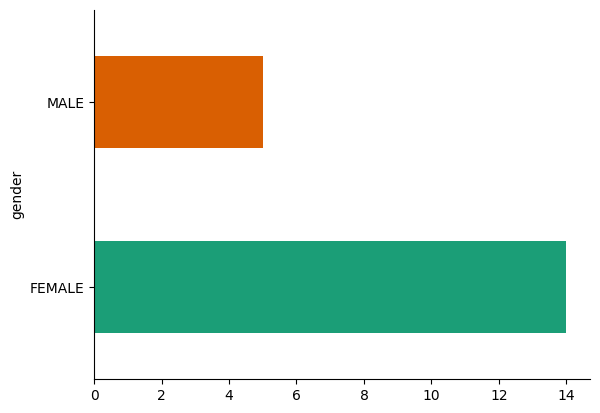

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

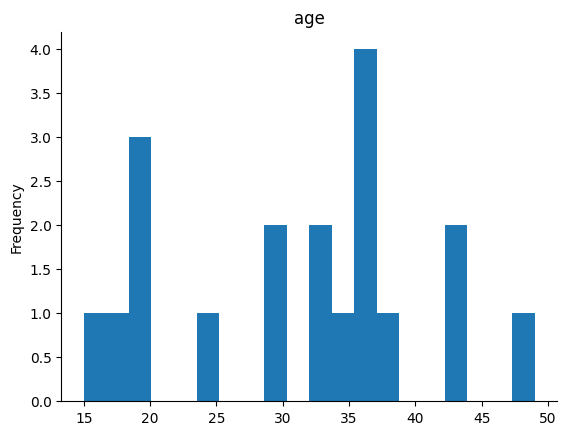

In [ ]:
# @title age

from matplotlib import pyplot as plt
df['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

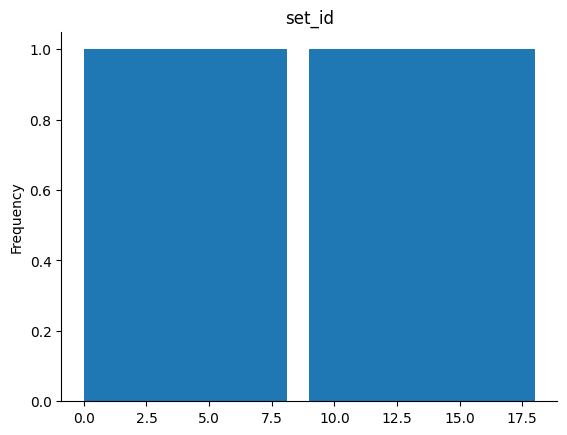

In [ ]:
# @title set_id

from matplotlib import pyplot as plt
df['set_id'].plot(kind='hist', bins=20, title='set_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

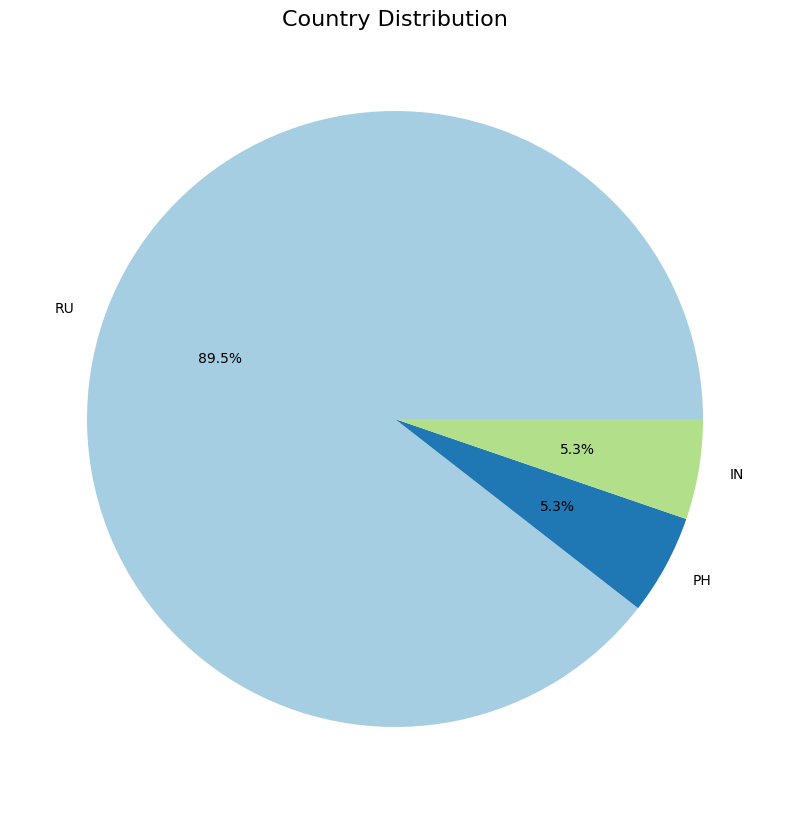

In [ ]:
# Pie chart for country distribution
country_counts = df['country'].value_counts()
plt.figure(figsize=(12, 10))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired(np.arange(len(country_counts))))
plt.title('Country Distribution', fontsize=16)
plt.show()

<Axes: >

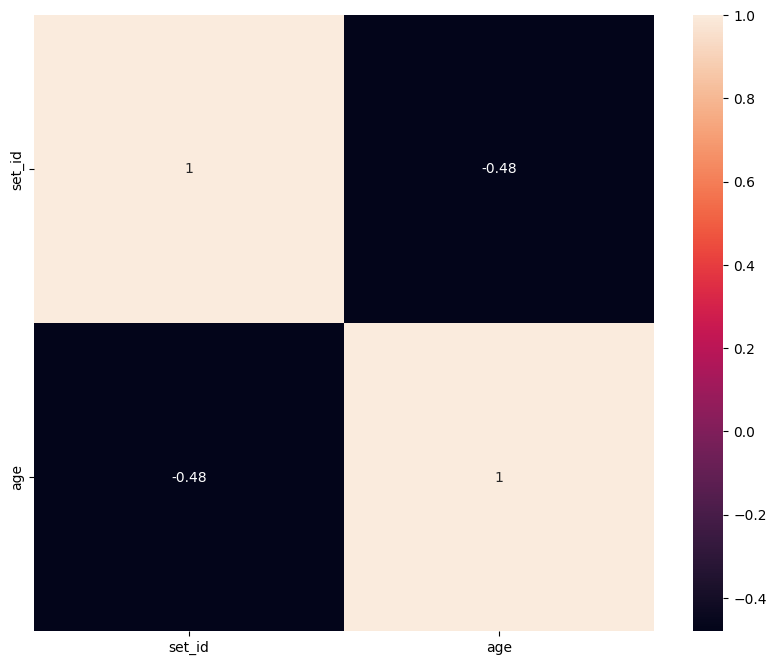

In [ ]:
plt.figure(figsize=(10,8))
numeric_cols=df.select_dtypes(include=[np.number])
corr=numeric_cols.corr()
sns.heatmap(corr,annot=True)

In [ ]:
df.head()

,set_id,gender,age,country
0,0,FEMALE,36,RU
1,1,FEMALE,37,RU
2,2,FEMALE,36,RU
3,3,MALE,29,RU
4,4,FEMALE,43,RU


In [ ]:
df['gender'] = df['gender'].str.strip().str.upper()


In [ ]:
df['gender_encoded'] = df['gender'].replace({'MALE': 0, 'FEMALE': 1})

print(df)




    set_id  gender  age country  gender_encoded
0        0  FEMALE   36      RU               1
1        1  FEMALE   37      RU               1
2        2  FEMALE   36      RU               1
3        3    MALE   29      RU               0
4        4  FEMALE   43      RU               1
5        5    MALE   49      RU               0
6        6  FEMALE   38      RU               1
7        7    MALE   19      PH               0
8        8  FEMALE   29      RU               1
9        9  FEMALE   32      RU               1
10      10    MALE   33      IN               0
11      11  FEMALE   15      RU               1
12      12  FEMALE   34      RU               1
13      13  FEMALE   43      RU               1
14      14  FEMALE   20      RU               1
15      15  FEMALE   18      RU               1
16      16  FEMALE   37      RU               1
17      17  FEMALE   24      RU               1
18      18    MALE   19      RU               0


<ipython-input-18-77fcf88c6be5>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender_encoded'] = df['gender'].replace({'MALE': 0, 'FEMALE': 1})


In [ ]:
def load_data():
    images = []
    labels = []

    for emotion_label, emotion in enumerate(EMOTIONS):
        # Get the directory for the current emotion
        emotion_dir = os.path.join(DATA_DIR, str(emotion_label))
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_file)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                images.append(img_resized)
                labels.append(emotion_label)  # Assigning label based on index
        else:
            print(f"Directory not found for emotion {emotion}: {emotion_dir}")

    return np.array(images), np.array(labels)

# Load the data
images, labels = load_data()

In [ ]:
df['set_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

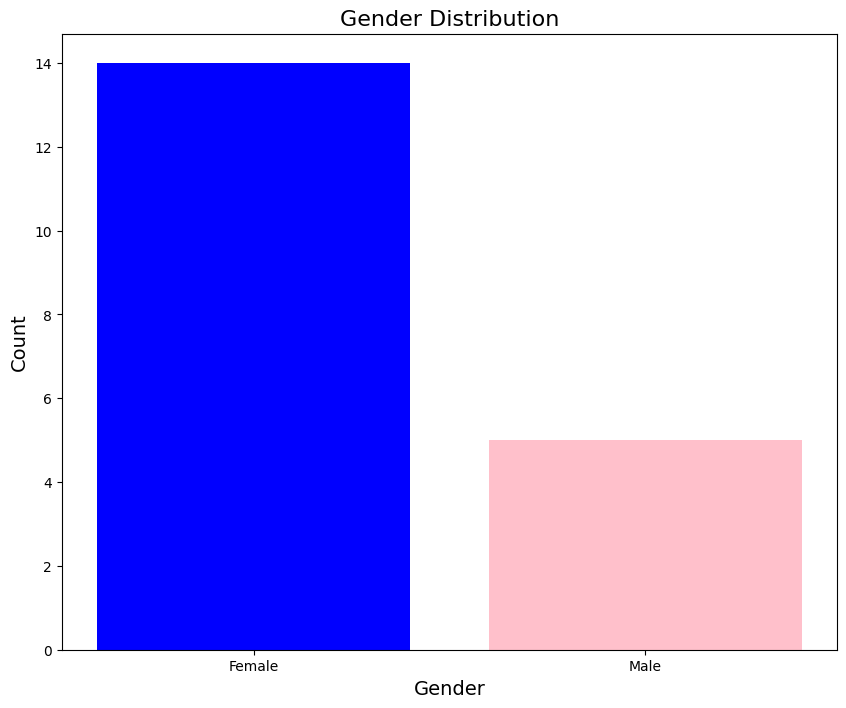

In [ ]:
plt.figure(figsize=(10, 8))
gender_counts = df['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink'])
plt.title('Gender Distribution', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

In [ ]:
images = images / 255.0

# Encode labels to categorical
labels_categorical = to_categorical(labels, num_classes=len(EMOTIONS))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

In [ ]:
def sample_pic(num):
  print(y_test[num])

  label = y_test[num].argmax(axis=0)
  plt.imshow(X_test[num].reshape(48, 48), cmap='gray')
  plt.title(EMOTIONS[label])
  plt.show()

[0. 0. 0. 0. 0. 0. 1.]


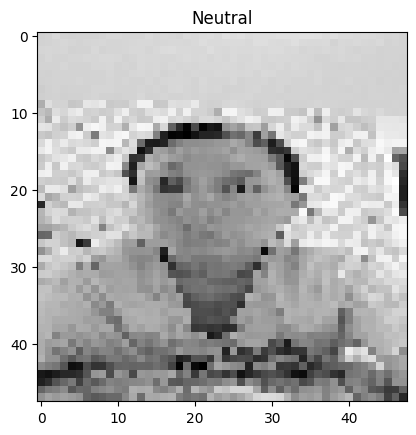

In [ ]:
sample_pic(10)

In [ ]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
model = Sequential()
model.add(Conv2D(32,kernel_size= (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(EMOTIONS), activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      15,860,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,882,631 (60.59 MB)

 Trainable params: 15,882,631 (60.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 934ms/step - accuracy: 1.0000 - loss: 0.0938 - val_accuracy: 1.0000 - val_loss: 0.0346
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 949ms/step - accuracy: 1.0000 - loss: 0.0439 - val_accuracy: 1.0000 - val_loss: 0.0231
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - accuracy: 1.0000 - loss: 0.0197 - val_accuracy: 1.0000 - val_loss: 0.0137
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 1.0000 - loss: 0.0279 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - accuracy: 1.0000 - loss: 0.0199 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss:

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0006221539224497974
Test accuracy: 1.0


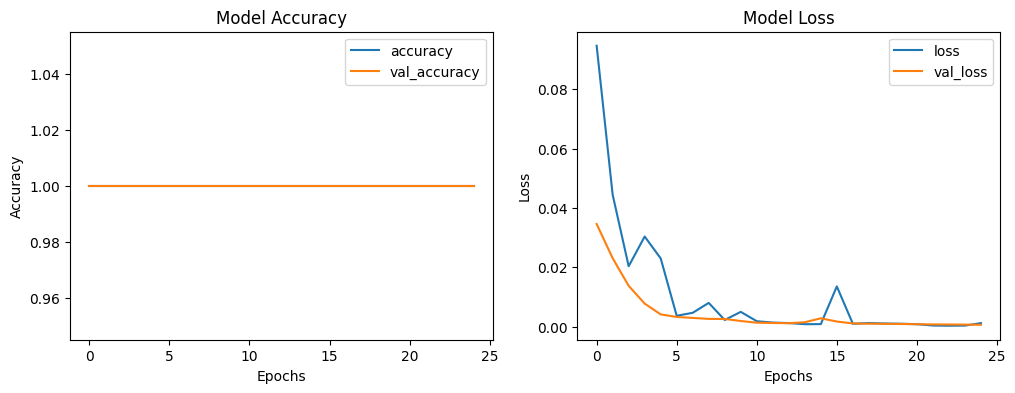

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


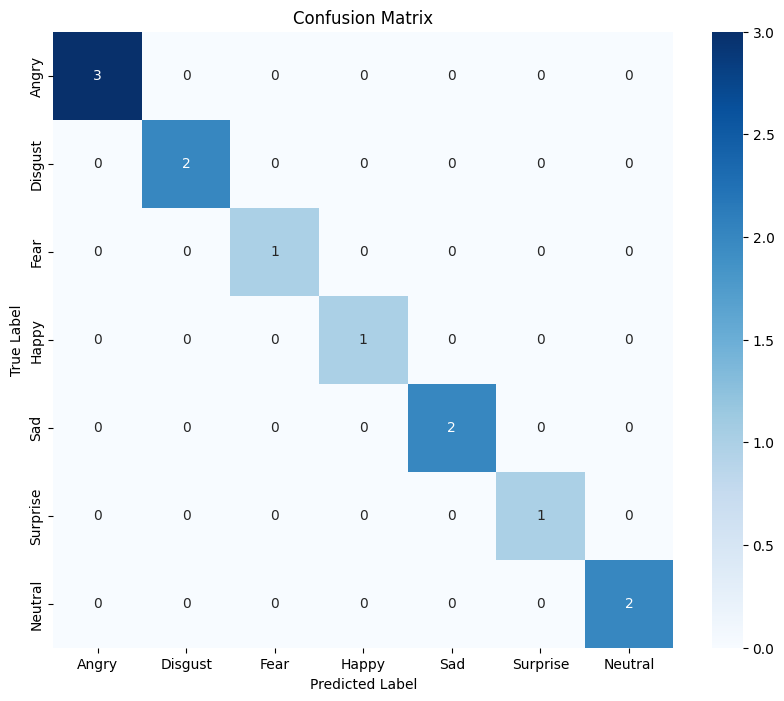

              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00         3
     Disgust       1.00      1.00      1.00         2
        Fear       1.00      1.00      1.00         1
       Happy       1.00      1.00      1.00         1
         Sad       1.00      1.00      1.00         2
    Surprise       1.00      1.00      1.00         1
     Neutral       1.00      1.00      1.00         2

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [ ]:
# Model Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_df = pd.DataFrame(cm, index=EMOTIONS, columns=EMOTIONS)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=EMOTIONS)
print(report)

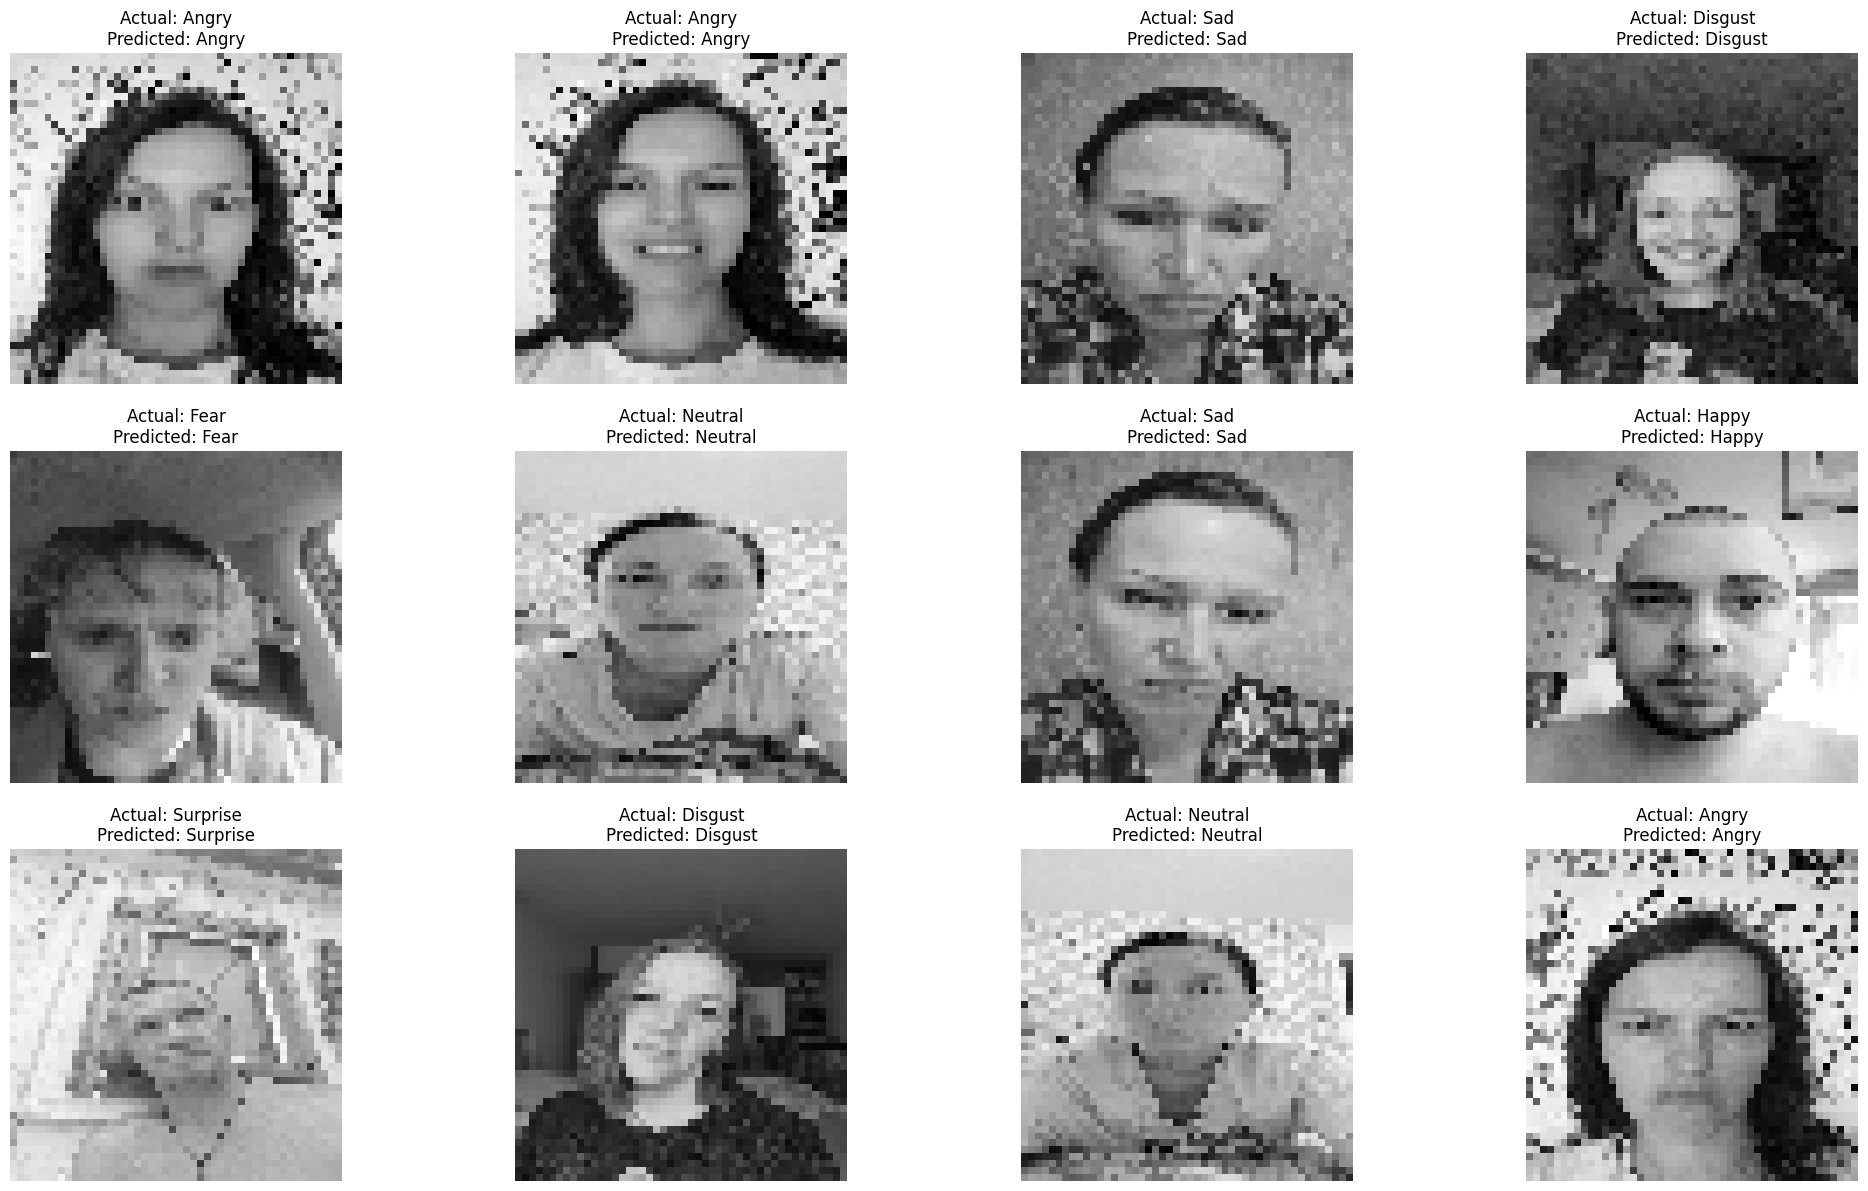

In [ ]:
num_of_images = min(20, len(X_test))
plt.figure(figsize=(25, 25))
for i in range(num_images):
    plt.subplot(5, 4, i + 1)
    img = (X_test[i] * 255).astype(np.uint8)  # Convert back to uint8
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f"Actual: {EMOTIONS[y_true[i]]}\nPredicted: {EMOTIONS[y_pred_classes[i]]}")
    plt.axis('off')
plt.show()

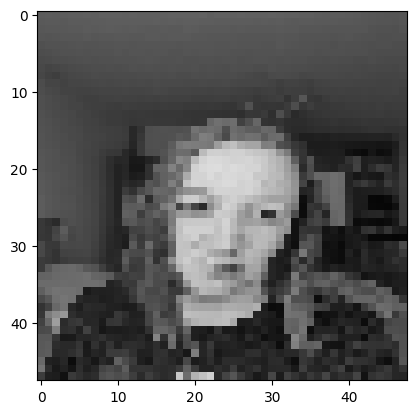

In [ ]:
img1 = (X_train[12]*255).astype(np.uint8)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

In [ ]:
y_test[5]

array([0., 0., 0., 0., 0., 0., 1.])

In [ ]:
y_pred[5]

array([1.0745015e-06, 1.5755246e-06, 4.5210213e-06, 1.3221157e-08,
       4.0819588e-05, 1.6512127e-08, 9.9995190e-01], dtype=float32)

In [ ]:
y_train[5]

array([1., 0., 0., 0., 0., 0., 0.])

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


In [ ]:
# Load and preprocess a new image
img_path = 'cropped.jpg'  # Path to the new image
img = image.load_img(img_path, target_size=(48, 48))  # Resize image to match model's input

# Convert the image to a NumPy array and scale it
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values (same as training)


In [ ]:
model.save("my_model.h5")  # Save model to an H5 file


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("my_model.h5")  # Load the saved model


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

# Load and preprocess the image
img_path = 'cropped (1).jpg'

# Convert image to grayscale (target_size must match model input size)
img = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
img_array = image.img_to_array(img)  # Shape: (48, 48, 1)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image

# Verify the shape
print("Image array shape:", img_array.shape)

# Predict using the model
predictions = model.predict(img_array)
print("Predictions:", predictions)


Image array shape: (1, 48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predictions: [[0.0429358  0.5407303  0.07014096 0.25583014 0.06498995 0.02472522
  0.00064757]]


NameError: name 'model' is not defined